# Importar librerías

In [142]:
import pandas as pd
from db_config import engine

# Extracción

In [143]:
query_base_general = "SELECT * FROM base_general"
df_base_general = pd.read_sql(query_base_general, engine)

In [144]:
query_localidad = "SELECT * FROM localidad"
df_localidad = pd.read_sql(query_localidad, engine)

In [145]:
df_localidad.head()

,id_persona,localidad,barrio,departamento
0,CC45557556,CIUDAD BOLIVAR,POTOSI,DISTRITO CAPITAL
1,CC10001851,SUBA,MAZUREN,DISTRITO CAPITAL
2,CC1010021417,KENNEDY,TUNDAMA II,DISTRITO CAPITAL
3,CC1022337888,KENNEDY,TUNDAMA II,DISTRITO CAPITAL
4,CC1032378916,BOSA,OLARTE,DISTRITO CAPITAL


In [146]:
df_base_general.head()

,id_persona,salario,segmento,grupo_familiar,edad,fecha_nacimiento,tipo_aportante,categoria,tipo_afiliado
0,CC1000000165,781242,Básico,0,20,11/11/1997 12:00:00,1,A,1
1,CC1000000189,862847,Joven,0,25,11/11/1997 12:00:00,1,A,1
2,CC1000000210,800000,Básico,2,30,11/11/1997 12:00:00,1,A,1
3,CC1000000213,781242+.00,Básico,4,25,11/11/1997 12:00:00,1,A,1
4,CC1000000255,781242+.00,Básico,1,25,11/11/1997 12:00:00,1,A,1


# Transformación

### Calidad de datos:


 Remover duplicados

In [147]:
#  Identificación de duplicados en la base general
duplicados_base_general = df_base_general[df_base_general.duplicated(subset=['id_persona'], keep=False)]

#  Mostrar cantidad de registros duplicados
num_duplicados_base_general = duplicados_base_general.shape[0]
print(f"Se encontraron {num_duplicados_base_general} registros duplicados en la base general")
df_base_general = duplicados_base_general.drop_duplicates(subset=['id_persona'], keep='first')

Se encontraron 40020 registros duplicados en la base general


In [148]:
#  Identificación de duplicados en la base general
duplicados_localidad = df_localidad[df_localidad.duplicated(subset=['id_persona'], keep=False)]

#  Mostrar cantidad de registros duplicados
num_duplicados_localidad = duplicados_localidad.shape[0]
print(f"Se encontraron {num_duplicados_localidad} registros duplicados en la localidad")
df_localidad = duplicados_localidad.drop_duplicates(subset=['id_persona'], keep='first')

Se encontraron 83481 registros duplicados en la localidad


Elimina espacios innecesarios

In [149]:
df_localidad = df_localidad.applymap(lambda x: x.strip() if isinstance(x, str) else x)
df_base_general = df_base_general.applymap(lambda x: x.strip() if isinstance(x, str) else x)

/tmp/ipykernel_47084/849203377.py:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_localidad = df_localidad.applymap(lambda x: x.strip() if isinstance(x, str) else x)
/tmp/ipykernel_47084/849203377.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_base_general = df_base_general.applymap(lambda x: x.strip() if isinstance(x, str) else x)


Join por el id_persona

In [150]:
df = pd.merge(df_base_general, df_localidad, on='id_persona', how='inner')

Definición de campos alfanumericos en id_persona

In [151]:
df = df.copy()
df = pd.DataFrame(df)
patron = r"([a-zA-Z0-9]+)"
df["field_clean"] = df["id_persona"].str.extract(patron, expand=False)
df["id_persona"] = df["field_clean"]
df["field_clean"] = df["id_persona"]
df = df[
    [
        "id_persona",
        "salario",
        "segmento",
        "grupo_familiar",
        "edad",
        "fecha_nacimiento",
        "tipo_aportante",
        "categoria",
        "tipo_afiliado",
        "localidad",
        "barrio",
        "departamento",
    ]
]
df.head()

,id_persona,salario,segmento,grupo_familiar,edad,fecha_nacimiento,tipo_aportante,categoria,tipo_afiliado,localidad,barrio,departamento
0,CC1000004980,1562484,Joven,0,18,11/11/1997 12:00:00,1,A,1,KENNEDY,CARVAJAL,DISTRITO CAPITAL
1,CC1000005012,1520139,Joven,0,23,11/11/1997 12:00:00,1,A,1,KENNEDY,TIMIZA,DISTRITO CAPITAL
2,CC1000005204,1562484,Medio,2,30,11/11/1997 12:00:00,1,A,1,CIUDAD BOLIVAR,INDIA CATALINA,DISTRITO CAPITAL
3,CC1000005260,1353717,Medio,1,30,11/11/1997 12:00:00,1,A,1,SANTAFE,EL TRIUNFO,DISTRITO CAPITAL
4,CC1000005485,616000,Básico,0,30,11/11/1997 12:00:00,1,A,1,USAQUEN,ACACIAS USAQUEN,DISTRITO CAPITAL


### Manejo de indicadores:

Afiliados hay por categoría y segmento poblacional.

In [156]:
afiliados_por_categoria_segmento = df.groupby(["categoria", "segmento"]).size().reset_index(name="cantidad")
print("Afiliados por categoria y segmento poblacional")
display(afiliados_por_categoria_segmento)

Afiliados por categoria y segmento poblacional


,categoria,segmento,cantidad
0,A,Básico,80
1,A,Joven,201
2,A,Medio,108
3,B,Joven,102
4,B,Medio,55
5,C,Alto,3
6,C,Joven,5
7,C,Medio,1


Conteo de afiliados por categoria barrrio/localidad

In [157]:
afiliados_por_categoria_localidad = df.groupby(["categoria","barrio", "localidad"]).size().reset_index(name="cantidad")
print("Afiliados por categoria barrio y localidad")
display(afiliados_por_categoria_localidad)

Afiliados por categoria barrio y localidad


,categoria,barrio,localidad,cantidad
0,A,A.S.D.,CIUDAD BOLIVAR,1
1,A,A.S.D.,SUBA,2
2,A,ACACIAS USAQUEN,USAQUEN,1
3,A,ALCALA,PUENTE ARANDA,1
4,A,ALFONSO LOPEZ,TEUSAQUILLO,1
...,...,...,...,...
420,C,LOS ROSALES,CHAPINERO,1
421,C,MARANTA III SECTOR,USAQUEN,1
422,C,SAN ANTONIO DE PADUA,ANTONIO NARIÑO,1
423,C,SANTA TERESA,USAQUEN,1


Generar visualización por segmento poblacional, localidad y categoría

In [158]:
import matplotlib.pyplot as plt
import seaborn as sns

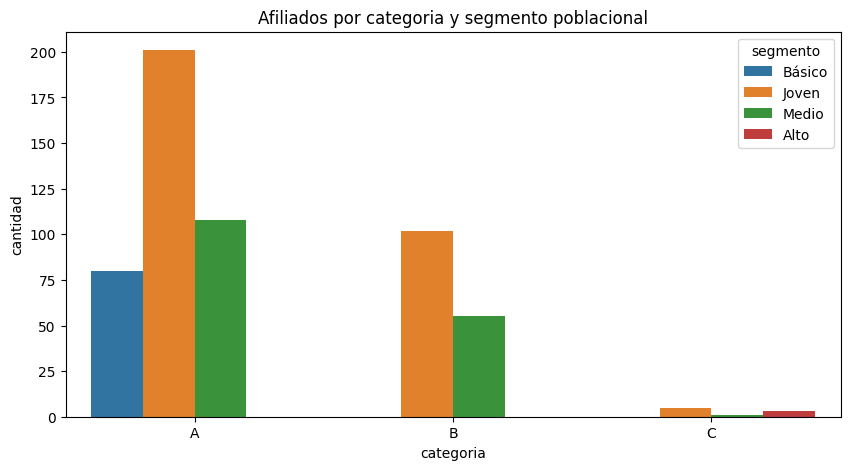

In [161]:
plt.figure(figsize=(10, 5))
sns.barplot(x="categoria", y="cantidad", hue="segmento", data=afiliados_por_categoria_segmento)
plt.title("Afiliados por categoria y segmento poblacional")
plt.xlabel("categoria")
plt.ylabel("cantidad")
plt.show()